In [ ]:
!pip install causalml
!pip install scikit-uplift catboost==0.22 -U

     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 327kB 6.6MB/s 
     |████████████████████████████████| 1.8MB 8.1MB/s 
  Created wheel for causalml: filename=causalml-0.9.0-cp36-cp36m-linux_x86_64.whl size=482231 sha256=2e1783c366a5ced0cde7c8314a33fba8db0f4ec54e0db599269fd6d957533462
  Stored in directory: /root/.cache/pip/wheels/6d/c4/e2/451f0ebc2f9a7540256b0a705a2fd09864893131aee58d5af9
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463911 sha256=f5614eea43f94cb7cc4246a62c6fe0f3470d89acada649b3deac57f86182194e
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
     |████████████████████████████████| 64.4MB 55kB/s 


In [ ]:
import io
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings
from sklearn.ensemble import RandomForestClassifier

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from sklift.viz import plot_qini_curve
from lightgbm import LGBMRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [ ]:
#uploading files from local to colab
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [ ]:
#Loading data as pandas dataframe
data_bank = pd.read_csv(io.StringIO(uploaded['bank-full.csv'].decode('utf-8')),sep=';')

#Direct uploading if not using colab
#data_bank = pd.read_csv("data/bank-full.csv",sep=';')


# Creating treatment col according to the contact
#"poutcome" should only be 'success' or 'failure' only- 5625 rows, '999' is control
data_bank = data_bank[:-1]
treatment = []*len(data_bank)
treatment_array = []*len(data_bank)
for x in data_bank['contact']:
  if x=="unknown":
    treatment.append(0)
    treatment_array.append('control')
  else:
    treatment.append(1)
    treatment_array.append('treatment')
data_bank['treatment']=treatment
data_bank = data_bank.drop('duration',axis=1)


# Encoding using lable encoder
categorical = ['job','marital','education','housing','loan','contact','month','poutcome','default','month','balance', 'y']
for c in categorical:
    data_bank[c] = LabelEncoder().fit_transform(data_bank[c])
    data_bank[c] = data_bank[c].astype('category')


In [ ]:
# separate array into input,output and treatment components
X = data_bank.drop(['treatment','y'],axis=1)
y= data_bank['y']
treatment = data_bank['treatment']
treatment_array = np.array(treatment_array)



treatment    32190
control      13020
dtype: int64

In [ ]:
data_bank


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,treatment
0,58,4,1,2,0,3036,1,0,2,5,8,1,-1,0,3,0,0
1,44,9,2,1,0,945,1,0,2,5,8,1,-1,0,3,0,0
2,33,2,1,1,0,918,1,1,2,5,8,1,-1,0,3,0,0
3,47,1,1,3,0,2420,1,0,2,5,8,1,-1,0,3,0,0
4,33,11,2,3,0,917,0,0,2,5,8,1,-1,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,9,2,1,0,1421,0,1,0,17,9,2,-1,0,3,1,1
45206,51,9,1,2,0,1741,0,0,0,17,9,3,-1,0,3,1,1
45207,71,5,0,0,0,2639,0,0,0,17,9,2,-1,0,3,1,1
45208,72,5,1,1,0,5455,0,0,0,17,9,5,184,3,2,1,1


In [ ]:
#Seperatng data into train and test

Xyt_train, Xyt_test = train_test_split(data_bank, test_size=0.5, random_state=42)

X_train = Xyt_train.drop(['y', 'treatment'], axis=1)
y_train = Xyt_train['y']
treatment_train = Xyt_train['treatment']


X_test = Xyt_test.drop(['y', 'treatment'], axis=1)
y_test = Xyt_test['y']
treatment_test = Xyt_test['treatment']




X- learner RF

In [ ]:
#Training model and calculating cate for X-learner(base learner Randomforest)

learner_x_rf = BaseXRegressor(learner=RandomForestClassifier(n_estimators=100))
learner_x_rf.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_rf = learner_x_rf.predict(X=X_test, treatment=treatment_test).flatten()

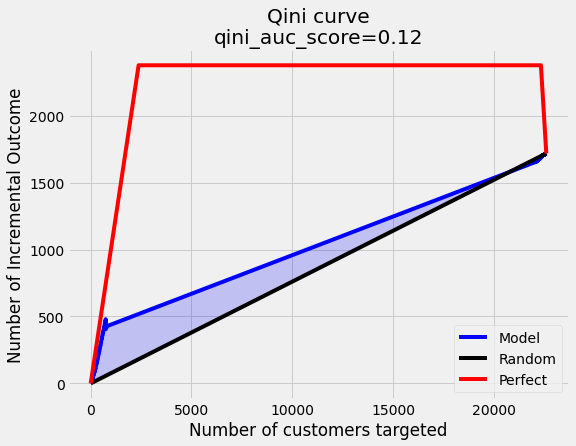

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_x_rf, treatment=treatment_test)

plt.xlabel('Number of customers targeted')
plt.ylabel('Number of Incremental Outcome')
plt.legend() 
plt.show()

S- learner RF

In [ ]:
#Training model and calculating cate for S-learner(base learner Randomforest)

learner_s_rf = BaseSRegressor(learner=RandomForestClassifier(n_estimators=100))
learner_s_rf.fit_predict(X=X_train, treatment=treatment_train, y=y_train)
cate_s_rf_test = learner_s_rf.predict(X=X_test, treatment=treatment_test).flatten()

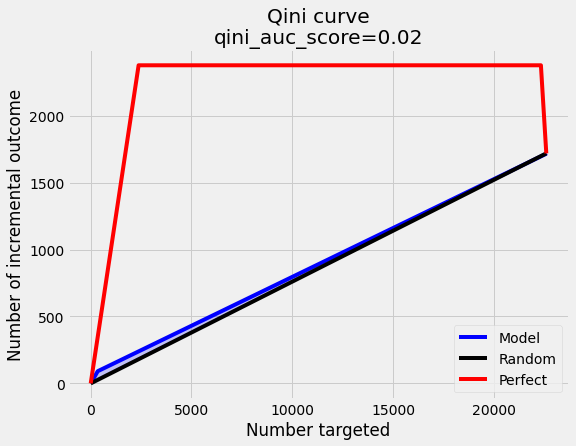

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_s_rf_test, treatment=treatment_test)


T- learner RF

In [ ]:
#Training model and calculating cate for T-learner(base learner Randomforest)

learner_t_rf = BaseTRegressor(learner=RandomForestClassifier(n_estimators=100))
learner_t_rf.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_t_rf_test = learner_t_rf.predict(X=X_test, treatment=treatment_test).flatten()

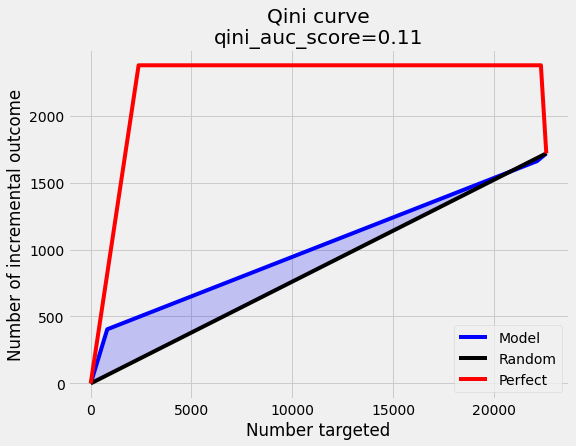

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_t_rf_test, treatment=treatment_test)


X-learner XGBoost

In [ ]:
#Training model and calculating cate for X-learner(base learner XGBoost)

learner_x_xgb = BaseXRegressor(learner=XGBRegressor())
learner_x_xgb.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test_xgb = learner_x_xgb.predict(X=X_test, treatment=treatment_test).flatten()

[09:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


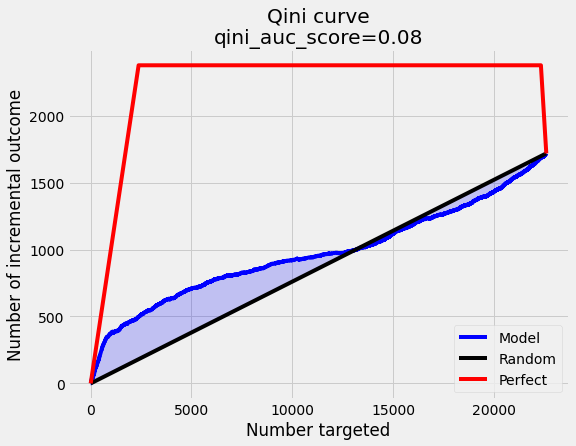

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_x_test_xgb, treatment=treatment_test)


S-learner XGBoost

In [ ]:
#Training model and calculating cate for S-learner(base learner XGBoost)

learner_s_xgb = BaseSRegressor(learner=XGBRegressor())
learner_s_xgb.fit_predict(X=X_train, treatment=treatment_train, y=y_train)
cate_s_xgb_test = learner_s_xgb.predict(X=X_test, treatment=treatment_test).flatten()

[09:10:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


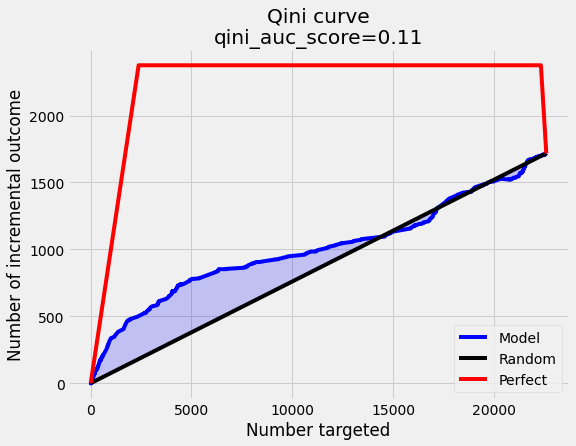

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_s_xgb_test, treatment=treatment_test)


T- learner XGBoost

In [ ]:
#Training model and calculating cate for T-learner(base learner XGBoost)


learner_t_xgb = BaseTRegressor(learner=XGBRegressor())
learner_t_xgb.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_t_xgb_test = learner_t_xgb.predict(X=X_test, treatment=treatment_test).flatten()

[09:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


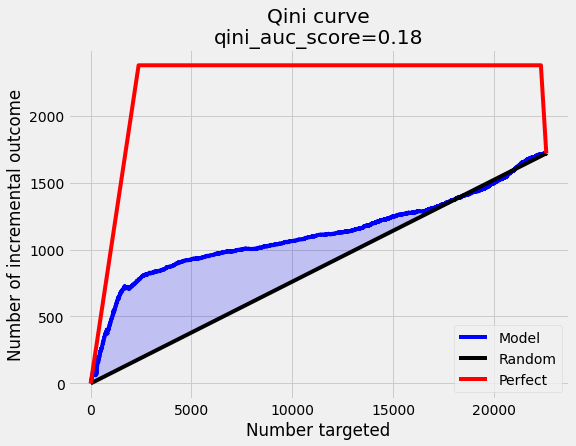

In [ ]:
#plotting qini
plot_qini_curve(y_true=y_test, uplift=cate_t_xgb_test, treatment=treatment_test)
